In [1]:
import torch
import torch.nn as nn
from pathlib import Path
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from math import *
from random import gauss,seed
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import seaborn

In [2]:
from PythonModules.RESNET import RESNET, DensityEstimator

In [3]:
import sys 
sys.path.insert(0,'/home/mohit.kumargupta/deep_boltzmann')
from matplotlib import rcParams
import keras
import tensorflow as tf
from deep_boltzmann.models import ParticleDimer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet, create_RealNVPNet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.sampling.latent_sampling import BiasedModel
from deep_boltzmann.sampling.permutation import HungarianMapper
from deep_boltzmann.util import load_obj, save_obj
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

Using TensorFlow backend.
/home/mohit.kumargupta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohit.kumargupta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohit.kumargupta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohit.kumargupta/.local/lib/p

In [4]:
trajdict = np.load('output.npz')
import ast
#params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [5]:
class combineModel(nn.Module):
    def __init__(self,model1,model2,model3):
        super(combineModel,self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
    
    def forward(self,inp):
        out = self.model1(inp)
        out = torch.reshape(out,(out.shape[0],1,8,8))
        #print(out)
        o1 = out
        out = self.model2(out)
        o2 = out
        #out = 36*torch.softmax( torch.reshape(out,(out.shape[0],16*16)), 1)
        #print(out.shape[0])
        #out = torch.reshape(out,(out.shape[0],1,16,16))
        
        #print(out)
        out = self.model3(out)
        #out = 36*torch.softmax( torch.reshape(out,(out.shape[0],32*32)), 1)
        #out = torch.reshape(out,(out.shape[0],1,32,32))
        
        return out

In [6]:
class ConfigurationModel(nn.Module):
    
    def __init__(self,model1):
        super(ConfigurationModel,self).__init__()
        self.model1 = model1
        self.hidden_dim = 32*16
        self.out_dim = 72
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.fc1 = nn.Linear(32*32, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, 32*16)
        self.fc3 = nn.Linear(32*16, 16*16)
        #self.lstm = nn.LSTM(hidden_dim, output_dim)
        #self.fc3 = nn.Linear(self.hidden_dim*4*4, hidden_dim*4)
        self.fc4 = nn.Linear(16*16, self.out_dim)
    
    def forward(self,inp):
        out = self.model1(inp)
        out = out.reshape((inp.shape[0],32*32))
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        return out

In [8]:
batch_size = 500
train_set = np.vstack([traj_open_train[1000:81000 :2], traj_closed_train[1000:81000 :2] ] )

In [10]:
OpenTest_set = torch.from_numpy( traj_open_train[81000: :2] ).type('torch.FloatTensor')
OpenTestSet32 = torch.from_numpy( np.load('NewDataSet32.npy')[40000:49500] ).type('torch.FloatTensor')
OpenTestDset = torch.cat( (OpenTest_set[:,:4], OpenTestSet32.reshape( (OpenTestSet32.shape[0], 32*32) ) ),1)

In [11]:
OpenTest_set = torch.from_numpy( traj_closed_train[81000: :2] ).type('torch.FloatTensor')
OpenTestSet32 = torch.from_numpy( np.load('NewDataSet32.npy')[89500:] ).type('torch.FloatTensor')
OpenTestDset = torch.cat( (OpenTest_set[:,:4], OpenTestSet32.reshape( (OpenTestSet32.shape[0], 32*32) ) ),1)

In [12]:
test_set = torch.from_numpy( np.vstack([traj_open_train[81000: :2], traj_closed_train[81000::2]]) ).type('torch.FloatTensor')
testSet32 = torch.from_numpy( np.vstack([np.load('NewDataSet32.npy')[40000:49500], np.load('NewDataSet32.npy')[89500:] ] )  ).type('torch.FloatTensor')

In [13]:
testDset = torch.cat( (test_set[:,:4], testSet32.reshape( (testSet32.shape[0], 32*32) ) ),1)

In [14]:
inputData = torch.from_numpy(train_set[:80000,:4]).type('torch.FloatTensor')
dataSet32 = torch.from_numpy( np.concatenate( (np.load('NewDataSet32.npy')[:40000], np.load('NewDataSet32.npy')[49500:89500] )) ).type('torch.FloatTensor')

In [42]:
test_loader =   torch.utils.data.DataLoader(OpenTestDset.type('torch.FloatTensor').to('cuda'), batch_size=batch_size)

In [15]:
dset = torch.cat((inputData,torch.reshape(dataSet32,(dataSet32.shape[0],32*32))),1 )

In [16]:
train_loader = torch.utils.data.DataLoader(dset.type('torch.FloatTensor').to('cuda'), batch_size=batch_size,shuffle= True)

In [17]:
model1 = DensityEstimator(4,64)
model2 = RESNET(18)
model3 = RESNET(18)

In [18]:
CombineModel = combineModel(model1,model2,model3)

In [19]:
CombineModel.load_state_dict(torch.load('NewCombineDensityEstimator4-64'))

<All keys matched successfully>

In [20]:
CombineModel.eval()

combineModel(
  (model1): DensityEstimator(
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (fc1): Linear(in_features=4, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=64, bias=True)
  )
  (model2): RESNET(
    (conv_input): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (residual): Sequential(
      (0): Residual_Block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (in1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.2, inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [21]:
conModel = ConfigurationModel(CombineModel.to('cuda')).to('cuda')

In [37]:
adOptimizer = optim.Adam(conModel.parameters(),lr =0.00001)

In [23]:
boxes = []
sz =32
x = -3.25
while x< 3.25:
        y = -3.25
        while(y<3.25):
            boxes.append([x+3.25/sz, y +3.25/sz])
            y+= (3.25*2)/sz   
        x += (3.25*2)/sz
boxes = np.array(boxes)
boxes = np.tile(boxes,(36,1,1))

In [24]:
boxes = torch.from_numpy(boxes).type('torch.FloatTensor').to('cuda')

In [25]:
print(boxes.shape)

torch.Size([36, 1024, 2])


In [35]:
def myFunc(output,data32):
    global boxes
    boxing = boxes.unsqueeze(0).expand((output.shape[0],-1,-1,-1))
    sz = 32
    vol = (3.25*2/sz)**2
    #print( torch.reshape(output,(output.shape[0],36,2)).unsqueeze(2).shape)
    snap =  torch.reshape(output,(output.shape[0],36,2)).unsqueeze(2).expand( (-1,-1,1024,-1))
    dist = torch.norm(snap-boxing,dim = 3)
    #print(dist.shape)
    val =  vol * torch.exp(-0.5*torch.mul((dist/0.4), (dist/0.4)) )/ (2*3.14 * 0.16)
    #print(val.sum(axis=1).shape)
    dataSet32 = val.sum(axis=1).reshape(val.shape[0],32,32)
    #print(dataSet32.shape)
    #dataSet32 = torch.reshape(torch.from_numpy(dataSet32), (len(dataSet32),sz,sz) )
    return (torch.abs(dataSet32-data32)/data32).mean()

In [27]:
sampleBox = []

In [28]:
for i in range(6):
    for j in range(6):
        sampleBox.append(i-2.5)
        sampleBox.append(j-2.5)

In [29]:
sampleBox = torch.from_numpy(np.array(sampleBox)).type('torch.FloatTensor').to('cuda')

In [30]:
print(sampleBox.size())

torch.Size([72])


In [31]:
print(dataSet32.shape)

torch.Size([80000, 32, 32])


In [32]:
boxes.shape

torch.Size([36, 1024, 2])

In [33]:
Epochs = 100

In [60]:
conModel.load_state_dict(torch.load('conModel34'))
conModel.eval()

ConfigurationModel(
  (model1): combineModel(
    (model1): DensityEstimator(
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (fc1): Linear(in_features=4, out_features=16, bias=True)
      (fc2): Linear(in_features=16, out_features=64, bias=True)
      (fc3): Linear(in_features=64, out_features=256, bias=True)
      (fc4): Linear(in_features=256, out_features=64, bias=True)
    )
    (model2): RESNET(
      (conv_input): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (residual): Sequential(
        (0): Residual_Block(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (in1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [38]:
for epoch in range(Epochs):
    totalLoss = 0.0
    print(epoch)
    #if((epoch+1)%2 == 0):
    #    torch.save(conModel.state_dict(), 'conModel4-72')
    for i,data in enumerate(train_loader,1):
        adOptimizer.zero_grad()
        out = conModel(data[:,:4])
        #print(out)
        #l1 = torch.sqrt( nn.MSELoss()(out,sampleBox.unsqueeze(0).expand(out.shape[0],-1)))
        #print(data.type(),out.type())
        l2 = myFunc(out, data[:,4:].reshape((data.shape[0],32,32)))
        loss = l2
        loss.backward()
        print(i,loss.item())
        totalLoss += loss.item()
        if(math.isnan(loss.item()) or math.isinf(loss.item())):
            break
        adOptimizer.step()
    print(totalLoss)

0
1 0.18538318574428558
2 0.18683357536792755
3 0.18822108209133148
4 0.18721991777420044
5 0.1865224391222
6 0.18763448297977448
7 0.1894112080335617
8 0.1884744018316269
9 0.18678180873394012
10 0.18883644044399261
11 0.18761390447616577
12 0.18674613535404205
13 0.18978603184223175
14 0.18815134465694427
15 0.1880926936864853
16 0.18836592137813568
17 0.18949949741363525
18 0.18815924227237701
19 0.18805941939353943
20 0.1869836151599884
21 0.1897040158510208
22 0.18791095912456512
23 0.18483637273311615
24 0.18806128203868866
25 0.19081710278987885
26 0.18663114309310913
27 0.1860053539276123
28 0.19005420804023743
29 0.189752995967865
30 0.18406440317630768
31 0.18886807560920715
32 0.18871253728866577
33 0.187834694981575
34 0.1848287433385849
35 0.19026419520378113
36 0.18781332671642303
37 0.18750129640102386
38 0.18749700486660004
39 0.1844610869884491
40 0.18357034027576447
41 0.18548449873924255
42 0.18769900500774384
43 0.18903830647468567
44 0.1876230686903
45 0.1875274032

37 0.1884051263332367
38 0.18531249463558197
39 0.1848534643650055
40 0.18532694876194
41 0.18724070489406586
42 0.189069002866745
43 0.18453378975391388
44 0.19102133810520172
45 0.1865418702363968
46 0.18839332461357117
47 0.18534696102142334
48 0.18477670848369598
49 0.1856861263513565
50 0.18767870962619781
51 0.18784011900424957
52 0.18521258234977722
53 0.1864032745361328
54 0.18239884078502655
55 0.1854550689458847
56 0.18626777827739716
57 0.18768824636936188
58 0.1905776709318161
59 0.1843724548816681
60 0.1873003989458084
61 0.18646694719791412
62 0.18909209966659546
63 0.18934275209903717
64 0.1868981420993805
65 0.18649497628211975
66 0.18685071170330048
67 0.18697217106819153
68 0.18608611822128296
69 0.18460218608379364
70 0.1880199909210205
71 0.1880684196949005
72 0.18842822313308716
73 0.18737226724624634
74 0.18717285990715027
75 0.18603359162807465
76 0.18847410380840302
77 0.18492314219474792
78 0.1834917962551117
79 0.18105541169643402
80 0.1874266415834427
81 0.18

KeyboardInterrupt: 

In [134]:
torch.save( conModel.state_dict(), 'conModel34')

In [135]:
torch.save( conModel.state_dict(), 'conModel4-72')

In [39]:
model = ParticleDimer()

In [40]:
Energy = None
Final = None

In [43]:
%%time
for i,data in enumerate(test_loader,1):
        out = conModel(data[:,:4])
        final = torch.cat( (data[:,:4],out),1).to('cpu')
        if(Final is not None):
            Final = np.concatenate((Final,final.detach().numpy()) )
        else:
            Final = final.detach().numpy()
        #print(final[10])
        
        if(Energy is None):
            Energy = model.energy(final.to('cpu').detach().numpy() )
        else: 
            Energy = np.concatenate((Energy, model.energy(final.to('cpu').detach().numpy())) )
        #print(model.energy(final.to('cpu').detach().numpy()) )
        #break

CPU times: user 2.89 s, sys: 462 ms, total: 3.35 s
Wall time: 3.35 s


In [43]:
ind = np.argwhere(Energy>200)

In [45]:
print(ind[50],ind[60],ind[70],ind[80])

[6231] [6241] [6251] [6261]


In [44]:
print(ind.shape)

(556, 1)


None


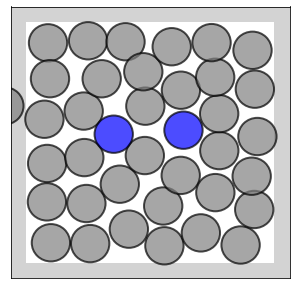

In [55]:
print(model.draw_config(Final[ind[150]]) )

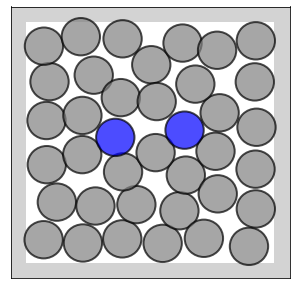

In [56]:
model.draw_config(traj_open_train[81000: :2][ind[150]])

In [49]:
Energy2 = model.energy(traj_closed_train[81000: :2] )

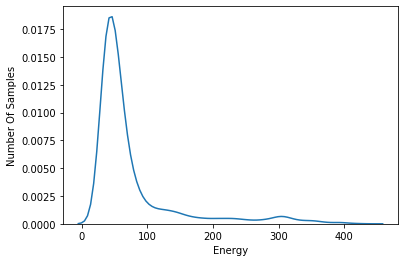

In [46]:
plt.xlabel('Energy')
plt.ylabel('Number Of Samples')
seaborn.kdeplot(Energy )
#plt.hist(Energy2, bins=200, histtype= 'step', range=(20,350), label = "MC sim" )
#plt.savefig('ClosedHistogram')

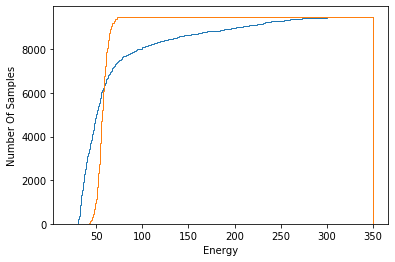

In [60]:
plt.xlabel('Energy')
plt.ylabel('Number Of Samples')
plt.hist(Energy, bins=500,cumulative= True, histtype= 'step',range=(20,350))
plt.hist(Energy2, bins=500,cumulative= True, histtype= 'step',range=(20,350))
plt.savefig('ClosedCumulativeHistogram')

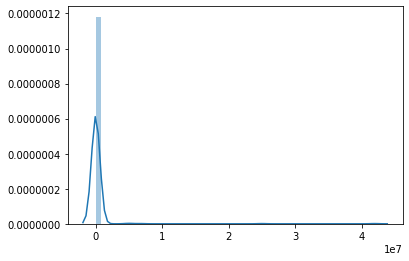

In [57]:
seaborn.distplot(Energy)

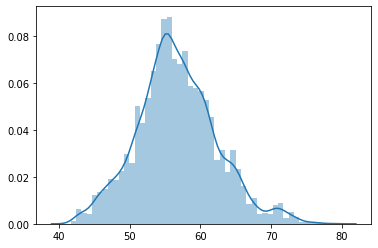

In [42]:
seaborn.distplot(Energy2)

In [48]:
def DensityDistribution(train_set):
    sz = 32
    boxes = []
    x = -3.25
    while x< 3.25:
            y = -3.25
            while(y<3.25):
                boxes.append([x+3.25/sz, y +3.25/sz])
                y+= (3.25*2)/sz   
            x += (3.25*2)/sz
    dataSet32 = []
    vol = (3.25*2/sz) **2
    for Snapshot in train_set:
        snap = np.transpose( np.tile(np.reshape(Snapshot[4:],(36,2) ), (1024,1,1)), (1,0,2))
        dist = np.linalg.norm(snap-boxes,axis = 2)
        val =  vol * np.exp(-0.5*np.square(dist/0.5))/ (2*np.pi * 0.25)
        dataSet32.append(val.sum(axis=0))
    dataSet32 = np.reshape(np.array(dataSet32), (len(dataSet32),sz,sz) )
    return dataSet32

In [71]:
def generateDenser(dist):
    nSamples =500
    pi = 3.14
    x1 =  np.random.rand(nSamples) *0.1 - dist/2
    y1 = np.random.rand(nSamples) * 0.2 - 0.1
    angle = np.random.rand(nSamples) * np.pi/6 - np.pi/12
    #dist = dist - np.random.rand(nSamples)*0.4
    x2= x1 + dist *np.cos(angle)
    y2 = y1 + dist*np.sin(angle)
    return np.array(x1), np.array(y1), np.array(x2),np.array(y2) 

In [160]:
Samples = generateDenser(2.1)

In [161]:
Samples = np.transpose( np.array(Samples) )

In [162]:
out = conModel(torch.from_numpy(Samples).type('torch.FloatTensor').to('cuda'))

In [163]:
print(Samples[0])

[-1.02468798 -0.02539009  1.02127049 -0.49873342]


In [164]:
final = torch.cat( (torch.from_numpy(Samples).type('torch.FloatTensor').to('cuda') ,out),1).to('cpu')
Energy = model.energy(final.to('cpu').detach().numpy() )

In [165]:
ind = np.argwhere(Energy>150)

In [166]:
print(ind.shape)

(206, 1)


In [94]:
print(model.draw_config(final[ind[20]]) )

IndexError: index 20 is out of bounds for axis 0 with size 19

None


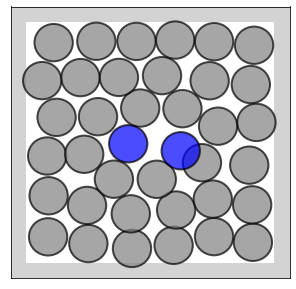

In [76]:
print(model.draw_config(final[ind[10]]) )